<a href="https://colab.research.google.com/github/rohitrao03/face_count/blob/master/happy_house.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from keras.utils import to_categorical

from keras.preprocessing.image import ImageDataGenerator

import keras 
from keras.models import load_model, Model

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import MaxPooling2D

from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Activation, Dropout
from keras.optimizers import Adam, RMSprop
from keras.layers.normalization import BatchNormalization

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score


Using TensorFlow backend.


In [0]:
def load_dataset():
    train_data = h5py.File('/content/drive/My Drive/happy house/train_happy.h5', "r")
    x_train = np.array(train_data["train_set_x"][:]) 
    y_train = np.array(train_data["train_set_y"][:]) 

    test_data = h5py.File('/content/drive/My Drive/happy house/test_happy.h5', "r")
    x_test = np.array(test_data["test_set_x"][:])
    y_test = np.array(test_data["test_set_y"][:]) 
    
    y_train = y_train.reshape((1, y_train.shape[0]))
    y_test = y_test.reshape((1, y_test.shape[0]))
    
    return x_train, y_train, x_test, y_test

In [0]:
X_train, Y_train, X_test, Y_test = load_dataset()



In [0]:
X_trainer = X_train/255.
X_tester = X_test/255.
Y_trainer = Y_train.T
Y_tester = Y_test.T

In [0]:
from google.colab import drive
drive.mount('/content/drive')

y = 1


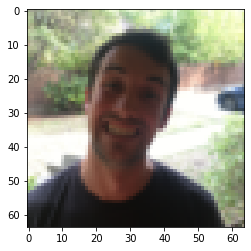

In [9]:
# Example of an image
index = 5
plt.imshow(X_train[index])
print ("y = " + str(np.squeeze(Y_train[:, index])))

In [0]:

yolo_model = load_model("/content/drive/My Drive/happy house/yolo.h5",compile=False)




In [16]:
yolo_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:

def change_model(model, new_input_shape=(None, 64, 64, 3)):
    # replace input shape of first layer
    model._layers[0].batch_input_shape = new_input_shape

    # rebuild model architecture by exporting and importing via json
    new_model = keras.models.model_from_json(model.to_json())

    # copy weights from old model to new one
    for layer in new_model.layers:
        try:
            layer.set_weights(model.get_layer(name=layer.name).get_weights())
            print("Loaded layer {}".format(layer.name))
        except:
            print("Could not transfer weights for layer {}".format(layer.name))

    return new_model

In [15]:
new_yolo_model=change_model(yolo_model)

new_yolo_model.summary()

Loaded layer input_1
Loaded layer conv2d_1
Loaded layer batch_normalization_1
Loaded layer leaky_re_lu_1
Loaded layer max_pooling2d_1
Loaded layer conv2d_2
Loaded layer batch_normalization_2
Loaded layer leaky_re_lu_2
Loaded layer max_pooling2d_2
Loaded layer conv2d_3
Loaded layer batch_normalization_3
Loaded layer leaky_re_lu_3
Loaded layer conv2d_4
Loaded layer batch_normalization_4
Loaded layer leaky_re_lu_4
Loaded layer conv2d_5
Loaded layer batch_normalization_5
Loaded layer leaky_re_lu_5
Loaded layer max_pooling2d_3
Loaded layer conv2d_6
Loaded layer batch_normalization_6
Loaded layer leaky_re_lu_6
Loaded layer conv2d_7
Loaded layer batch_normalization_7
Loaded layer leaky_re_lu_7
Loaded layer conv2d_8
Loaded layer batch_normalization_8
Loaded layer leaky_re_lu_8
Loaded layer max_pooling2d_4
Loaded layer conv2d_9
Loaded layer batch_normalization_9
Loaded layer leaky_re_lu_9
Loaded layer conv2d_10
Loaded layer batch_normalization_10
Loaded layer leaky_re_lu_10
Loaded layer conv2d_

In [0]:
from sklearn.preprocessing import LabelBinarizer

class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [0]:
lenc = MyLabelBinarizer()
Y_train1 =  lenc.fit_transform(Y_trainer)
Y_test1 =lenc.fit_transform(Y_tester)

In [0]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_trainer, y=Y_train1)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_tester, y=Y_test1)

In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [45]:
#adding dense and output layer
X1=new_yolo_model.layers[-1].output
X3=Flatten()(X1)
X4=Dense(units=256,activation='relu')(X3)
X5=Dense(units=128,activation='relu')(X4)
X6=Dense(2, activation = 'softmax')(X4)

yolo_model_final = Model(input = new_yolo_model.input, output = X6)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys


In [50]:
yolo_model_final.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 64, 64, 32)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
from keras.optimizers import Adam
opt = Adam(lr=0.0001)
#model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

yolo_model_final.compile(optimizer = opt, loss = keras.losses.categorical_crossentropy, metrics = ['accuracy'])


In [48]:
hist = yolo_model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 100, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

Epoch 1/100
10/10 [==============================] - 3s 284ms/step - loss: 0.6536 - accuracy: 0.8173 - val_loss: 0.6909 - val_accuracy: 0.8750

Epoch 00001: val_loss did not improve from 0.66463
Epoch 2/100
10/10 [==============================] - 3s 268ms/step - loss: 0.6193 - accuracy: 0.8281 - val_loss: 0.6757 - val_accuracy: 0.8125

Epoch 00002: val_loss did not improve from 0.66463
Epoch 3/100
10/10 [==============================] - 3s 268ms/step - loss: 0.6818 - accuracy: 0.8375 - val_loss: 0.5915 - val_accuracy: 0.7963

Epoch 00003: val_loss improved from 0.66463 to 0.59147, saving model to ieeercnn_vgg16_1.h5
Epoch 4/100
10/10 [==============================] - 3s 267ms/step - loss: 0.6631 - accuracy: 0.8013 - val_loss: 0.7089 - val_accuracy: 0.8125

Epoch 00004: val_loss did not improve from 0.59147
Epoch 5/100
10/10 [==============================] - 3s 266ms/step - loss: 0.6416 - accuracy: 0.8344 - val_loss: 0.8242 - val_accuracy: 0.8148

Epoch 00005: val_loss did not impro

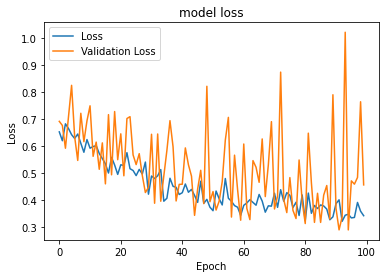

<Figure size 432x288 with 0 Axes>

In [49]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')